In [156]:
import numpy as np 
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind


## Descriptive Analysis

In [157]:
student_habits = pd.read_csv("../data/student_habits_performance.csv")
student_habits.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [158]:
# We do not need to know their id
student_habits = student_habits.drop("student_id", axis=1)
student_habits.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


#### We have a mixute of numeric and non-numeric columns. Lets take a look at each.

In [159]:
# Analyze numeric columns
student_habits.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [160]:
skew = student_habits['exam_score'].skew()
print(f'{skew:.3f}')

-0.156


#### The exam score standard deviation is relatively high, and two standard deviations above the mean (≈103.4) exceed the maximum possible score of 100. The max score being capped causes the distribution to not appear perfectly normal and slighly left-skewed with more students clustered near the upper limit of 100. 

In [161]:
exam_score = student_habits['exam_score']
mean = exam_score.mean()
se = exam_score.std(ddof=1) / np.sqrt(len(exam_score))
ci = stats.t.interval(0.95, df=len(exam_score)-1, loc=mean, scale=se)
print(f"95% CI for mean exam score: {ci}")

95% CI for mean exam score: (np.float64(68.55348547489275), np.float64(70.64951452510725))


#### Confidence interval shows between 68.56-70.65, so we can say we are 95% confident the true mean of the population lies between these values.

In [162]:
non_numeric = student_habits.select_dtypes(exclude=['number'])
non_numeric.head()

,gender,part_time_job,diet_quality,parental_education_level,internet_quality,extracurricular_participation
0,Female,No,Fair,Master,Average,Yes
1,Female,No,Good,High School,Average,No
2,Male,No,Poor,High School,Poor,No
3,Female,No,Poor,Master,Good,Yes
4,Female,No,Fair,Master,Good,No


In [163]:
for feature in non_numeric:
    print(feature, ":", non_numeric[feature].unique())

gender : ['Female' 'Male' 'Other']
part_time_job : ['No' 'Yes']
diet_quality : ['Fair' 'Good' 'Poor']
parental_education_level : ['Master' 'High School' 'Bachelor' nan]
internet_quality : ['Average' 'Poor' 'Good']
extracurricular_participation : ['Yes' 'No']


In [164]:
student_habits.isnull().sum()

age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

#### We have 91 NaN values in parental_education_level, we can dive further into that later.

# Data Visualization

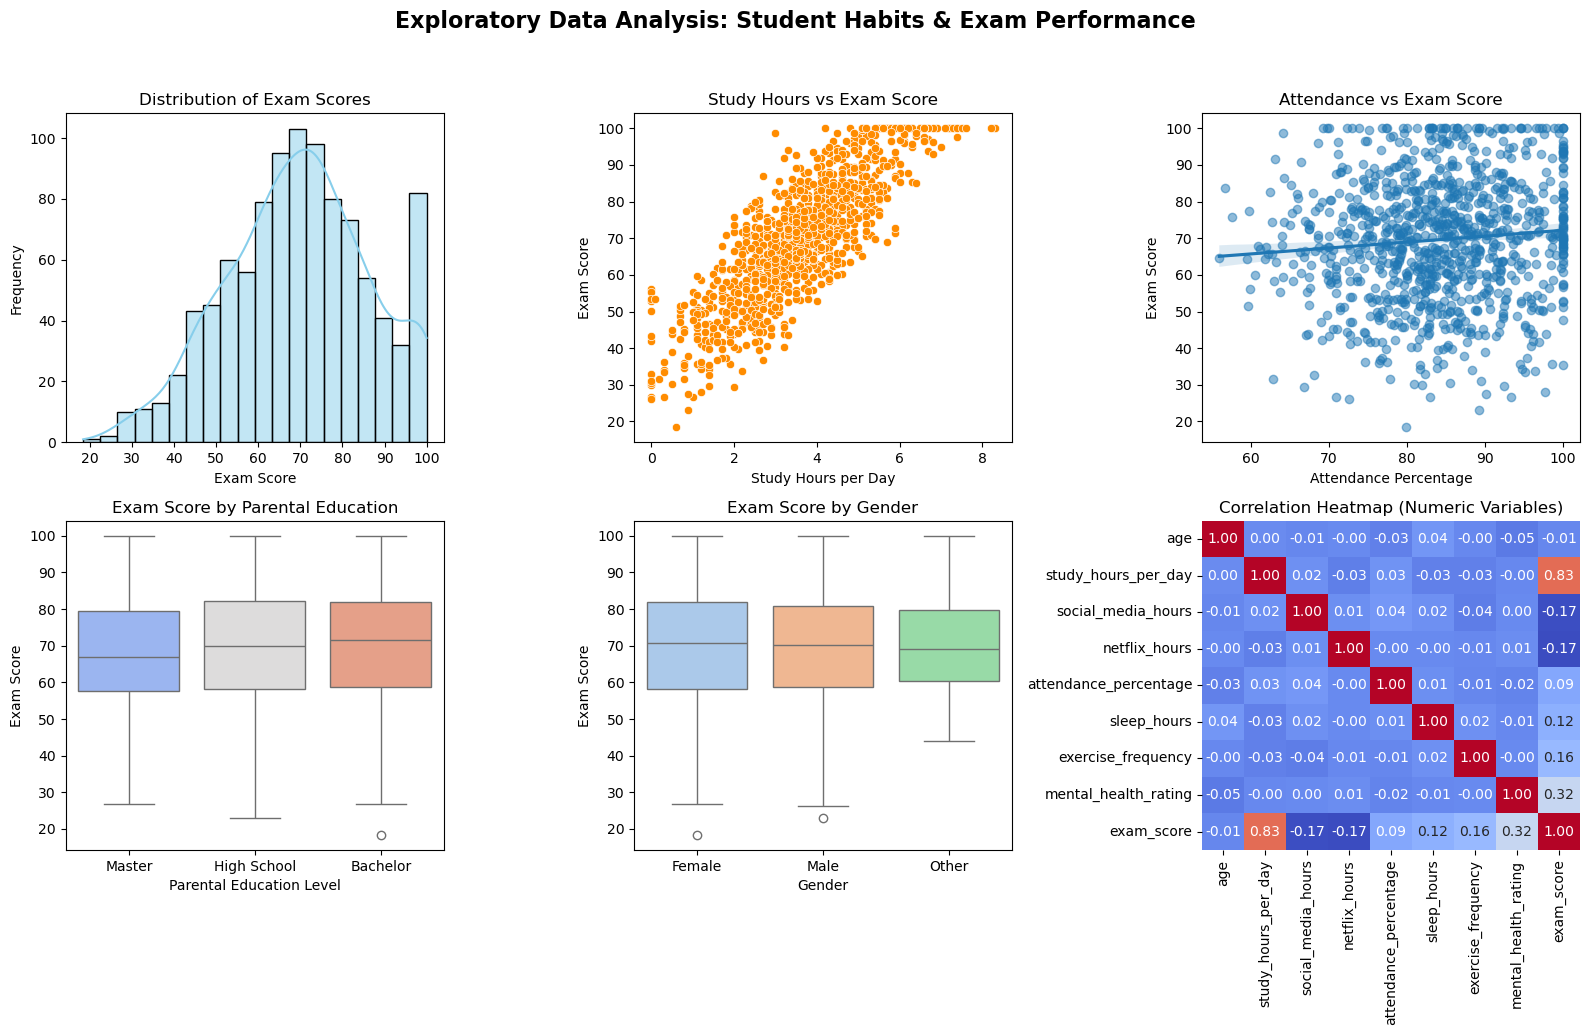

In [165]:
# Ensure numeric data are properly selected
num_df = student_habits.select_dtypes(include=['number'])

plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Histogram of exam scores
plt.subplot(2, 3, 1)
sns.histplot(student_habits['exam_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')

# Study hours vs Exam score (scatter)
plt.subplot(2, 3, 2)
sns.scatterplot(x='study_hours_per_day', y='exam_score', data=student_habits, color='darkorange')
plt.title('Study Hours vs Exam Score')
plt.xlabel('Study Hours per Day')
plt.ylabel('Exam Score')

# Attendance vs Exam score (regression line)
plt.subplot(2, 3, 3)
sns.regplot(x='attendance_percentage', y='exam_score', data=student_habits, scatter_kws={'alpha':0.5})
plt.title('Attendance vs Exam Score')
plt.xlabel('Attendance Percentage')
plt.ylabel('Exam Score')

# 4️⃣ Exam score by Parental Education (boxplot)
plt.subplot(2, 3, 4)
sns.boxplot(
    x='parental_education_level', y='exam_score',
    hue='parental_education_level', data=student_habits,
    palette='coolwarm', legend=False
)
plt.title('Exam Score by Parental Education')
plt.xlabel('Parental Education Level')
plt.ylabel('Exam Score')

# Exam score by Gender (boxplot)
plt.subplot(2, 3, 5)
sns.boxplot(
    x='gender', y='exam_score',
    hue='gender', data=student_habits,
    palette='pastel', legend=False
)
plt.title('Exam Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Exam Score')

# Correlation heatmap
plt.subplot(2, 3, 6)
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title('Correlation Heatmap (Numeric Variables)')

plt.suptitle('Exploratory Data Analysis: Student Habits & Exam Performance', fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

#### The histogram of exam scores shows a mostly normal distribution with a slight left skew, likely due to a concentration of high-achieving students. The scatterplot of Study Hours vs. Exam Score displays a clear positive linear trend, showing students who study more tend to perform better. Other visualizations suggest that some features have little impact on exam performance, and the correlation heatmap supports these observations by highlighting only a single meaningful relationships among the variables.

# Significance Testing and Comparing Groups

#### Handling Missing Values (parental_education_level)

Since the dataset contains `NaN` values for **parental education level** feature.  
There are two reasonable ways to interpret these missing entries:


1. **Assume they represent missing data**, meaning the information was not recorded or is unavailable.  
2. **Assume they represent education below high school level**, implying no formal schooling.  

Given that this dataset is **simulated** and the provider did **not explicitly specify** the meaning of these missing values, we will treat both interpretations as plausible scenarios.  
To assess their potential impact, we will perform **significance tests** (e.g., t-tests) to determine whether rows with missing parental education values show **different outcomes** in student performance compared to those with known values.


In short, we want to know if students with missing parental education data have different average final scores compared to students with known parental education levels.

In [166]:
student_habits["is_missing_parent_edu"] = student_habits["parental_education_level"].isna().astype(int)

known_scores = student_habits.loc[student_habits["is_missing_parent_edu"] == 0, "exam_score"]
missing_scores = student_habits.loc[student_habits["is_missing_parent_edu"] == 1, "exam_score"]

# H_0: mean = mean
# H_1: mean != mean
t_stat, p_val = ttest_ind(known_scores, missing_scores, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

T-statistic: -0.261, p-value: 0.7947


The t-statistic of -0.261 indicates that the means of the final exam scores differ by only about a quarter of a standard error, which is essentially negligible. The p-value (0.79) is well above any conventional significance level (alpha=0.05), so we fail to reject the null hypothesis. 

This suggests that whether a student’s parental education level is known or missing makes no meaningful difference in their final exam score.

### Lets move to apply education level "Below High School"

In [167]:
# Education dictionary
edu_order = {
    "Below High School": 0,
    "High School": 1,
    "Bachelor": 2,
    "Master": 3
}

# new column mapping education levels to their respective numerical values
student_habits["parental_education_level_num"] = (
    student_habits["parental_education_level"]
    .map(edu_order)
    .fillna(0)  # fill NaNs or unmapped with 0
)

# H_0: mean = mean
# H_1: mean != mean

# t-test whether parental education below highschool level affects exam score 
low = student_habits[student_habits['parental_education_level_num'] == 0]['exam_score']
high = student_habits[student_habits['parental_education_level'] != 0]['exam_score']
t_stat, p_val = ttest_ind(low, high, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

T-statistic: 0.238, p-value: 0.8122


The t-statistic of 0.238 indicates that the means of the final exam scores differ by only about a quarter of a standard error, which is essentially negligible. The p-value (0.812) is well above any conventional significance level (alpha=0.05), so we fail to reject the null hypothesis. 

This suggests that whether a student’s parental education level is "Below High School" or above makes no meaningful difference in their final exam score.

In [168]:
student_habits[['parental_education_level_num', 'exam_score']].describe()

,parental_education_level_num,exam_score
count,1000.000000,1000.000000
mean,1.593000,69.601500
std,0.870695,16.888564
min,0.000000,18.400000
25%,1.000000,58.475000
50%,2.000000,70.500000
75%,2.000000,81.325000
max,3.000000,100.000000


Text(0.5, 1.0, 'Exam Score by Parental Education Level')

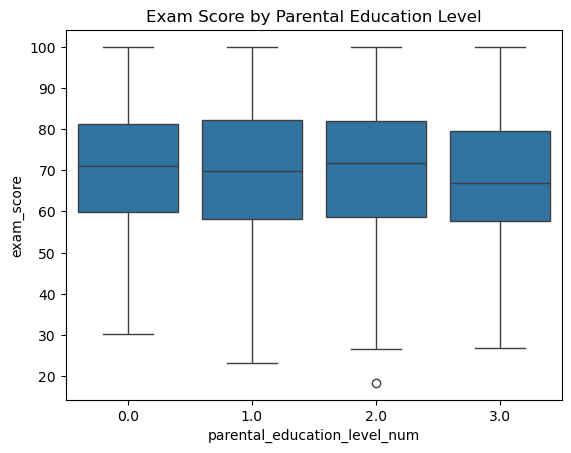

In [169]:
sns.boxplot(x='parental_education_level_num', y='exam_score', data=student_habits)
plt.title("Exam Score by Parental Education Level")

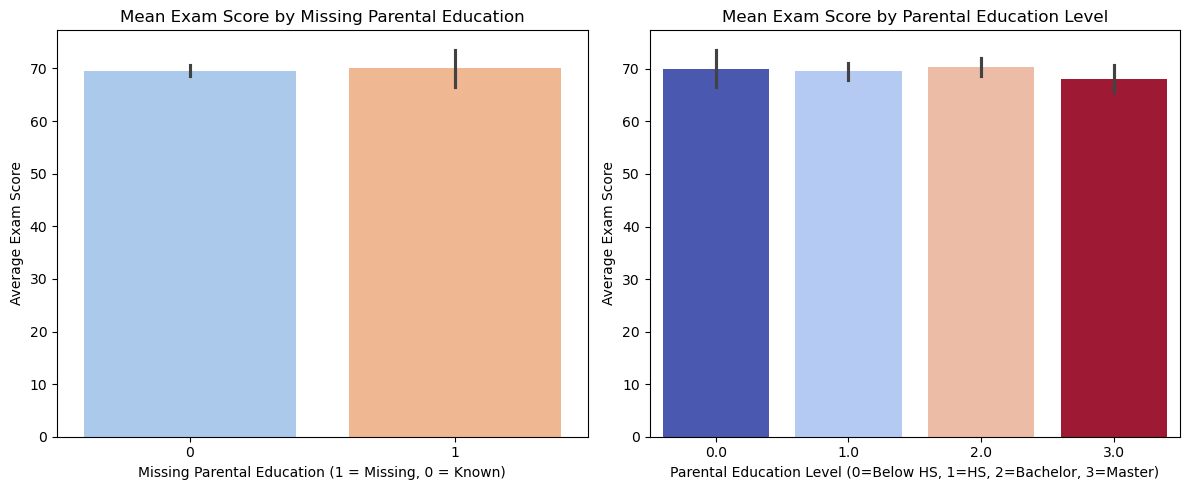

In [170]:
plt.figure(figsize=(12,5))

# Mean Exam Score by Missingness
plt.subplot(1,2,1)
sns.barplot(
    x='is_missing_parent_edu', y='exam_score',
    hue='is_missing_parent_edu', legend=False,
    data=student_habits, estimator='mean', errorbar=('ci',95),
    palette='pastel'
)
plt.title('Mean Exam Score by Missing Parental Education')
plt.xlabel('Missing Parental Education (1 = Missing, 0 = Known)')
plt.ylabel('Average Exam Score')

# Mean Exam Score by Education Level
plt.subplot(1,2,2)
sns.barplot(
    x='parental_education_level_num', y='exam_score',
    hue='parental_education_level_num', legend=False,
    data=student_habits, estimator='mean', errorbar=('ci',95),
    palette='coolwarm'
)
plt.title('Mean Exam Score by Parental Education Level')
plt.xlabel('Parental Education Level (0=Below HS, 1=HS, 2=Bachelor, 3=Master)')
plt.ylabel('Average Exam Score')

plt.tight_layout()
plt.show()

#### The visualizations of exam scores by parental education level support the results of the t-tests. The bar and box plots show that average exam scores are nearly identical across education levels, with overlapping confidence intervals. This aligns with the t-test results, which produced a high p-value (≈0.81), indicating no statistically significant difference in mean exam scores between students with missing or differing parental education levels. In other words, the data visualizations and inferential tests both suggest that parental education has little to no measurable effect on exam performance in this sample.